# 시작

In [80]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy

BATCH_SIZE = 16

# 데이터 전처리 & 읽어오기

In [81]:
def normalize_and_resize_img(data):
    image = tf.image.resize(data['image'], [224, 224])
    data['image'] = tf.cast(image, tf.float32) / 255.0
    return data['image'], data['label']

def apply_normalize_on_dataset(ds):
    return ds.map(normalize_and_resize_img, num_parallel_calls=2)\
            .batch(BATCH_SIZE)\
            .repeat()\
            .shuffle(200)\
            .prefetch(tf.data.experimental.AUTOTUNE)

In [82]:
def get_single(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    return sample_data[0]

# 모델 생성 & 훈련

In [83]:
def make_model(n_class):
    resnet = tf.keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg', 
    )
    outputs = tf.keras.layers.Dense(n_class, activation = 'softmax')(resnet.output)
    return tf.keras.Model(inputs=resnet.input, outputs=outputs)

In [84]:
def train_model(model, ds_train, ds_test, ds_info):
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(lr=0.01),
        metrics=['accuracy'],
    )
    return model.fit(
        apply_normalize_on_dataset(ds_train),
        steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
        validation_steps=int(ds_info.splits['test'].num_examples/16),
        epochs=15,
        validation_data=apply_normalize_on_dataset(ds_test),
        verbose=1,
        use_multiprocessing=True,
    )

# CAM & Grad CAM

In [85]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    image, label = normalize_and_resize_img(item)
    
    feature_map_output = model.layers[-3].output
    cam_model = tf.keras.models.Model([model.inputs], [feature_map_output, model.output])
    feature_map, pred = cam_model(tf.expand_dims(image, 0)) # feature map: (1, 7, 7, 2048)
    
    class_weights = model.layers[-1].get_weights()[0] # shape: (2048, 196)
    cam_image = np.zeros(dtype=np.float32, shape=feature_map.shape[1:3]) # shape: (7, 7)
    for i, score in enumerate(class_weights[:, label]):
        cam_image += score * feature_map[0, :, :, i]
        
    cam_image /= np.max(cam_image)
    cam_image = cam_image.numpy() # shape: (7, 7)
    cam_image = cv2.resize(cam_image, (width, height)) # shape: (224, 224)
    cam_image[cam_image<0]=0
    return cam_image

In [86]:
def generate_grad_cam(model, layer_name, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    image, label = normalize_and_resize_img(item)
    
    feature_map_output = model.get_layer(layer_name).output
    grad_model = tf.keras.models.Model([model.inputs], [feature_map_output, model.output])
    
    with tf.GradientTape() as tape:
        feature_map, predicts = grad_model(tf.expand_dims(image, 0))
        grad_val = tape.gradient(predicts[:, label], feature_map)[0]
    scores = np.mean(grad_val, axis=(0, 1))
    grad_cam = np.zeros(dtype=np.float32, shape=feature_map.shape[1:3])
    for i, score in enumerate(scores):
        grad_cam += score * feature_map[0, :, :, i]
        
    grad_cam /= np.max(grad_cam)
    grad_cam = grad_cam.numpy()
    grad_cam = cv2.resize(grad_cam, (width, height))
    grad_cam[grad_cam<0]=0
    return grad_cam

# 시각화

In [87]:
def draw_image_with_cam(item, cam):
    image = copy.deepcopy(item['image']).astype(np.uint8)
    cam = np.stack([cam*255]*3, axis=-1).astype(np.uint8)
    blended_image = cv2.addWeighted(cam, 0.5, image, 0.5, 0.0)
    plt.imshow(blended_image)

In [88]:
def get_bbox(cam):
    cam[cam<0.05] = 0
    cam = (cam*255).astype(np.uint8)
    contours,_ = cv2.findContours(cam, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rotated_rect = cv2.minAreaRect(contours[0])
    rect = cv2.boxPoints(rotated_rect)
    return np.int0(rect)


def rect_to_minmax(rect, image):
    return [
        rect[:,1].min()/float(image.shape[0]),
        rect[:,0].min()/float(image.shape[1]),
        rect[:,1].max()/float(image.shape[0]),
        rect[:,0].max()/float(image.shape[1])
    ]


def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


def draw_image_with_bbox(item, cam):
    image = copy.deepcopy(item['image'])
    cam = copy.deepcopy(cam)
    rect = get_bbox(cam)
    pred_bbox = rect_to_minmax(rect, image)
    iou = get_iou(item['bbox'], pred_bbox)
    print(f'IoU: {iou}')
    image = cv2.drawContours(image,[rect],0,(0,0,255),2)
    plt.imshow(image)

# 메인

In [89]:
(ds_train, ds_test), ds_info = tfds.load(
    'cars196',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
num_classes = ds_info.features["label"].num_classes

In [90]:
model = make_model(num_classes)
model.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

## 모델 훈련(한번만 수행)

In [ ]:
train_model(model, ds_train, ds_test, ds_info)

In [ ]:
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
model.save(cam_model_path)

## 모델 불러오기

In [91]:
cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
model = tf.keras.models.load_model(cam_model_path)

In [92]:
item = get_single(ds_test)

## CAM

In [93]:
cam = generate_cam(model, item)

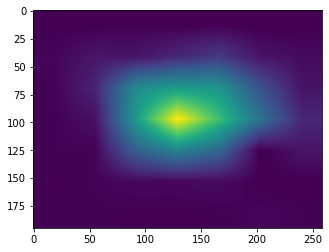

In [94]:
plt.imshow(cam)

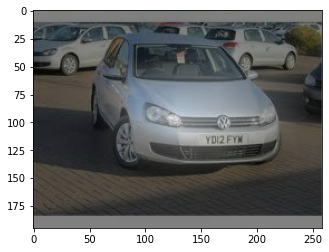

In [95]:
draw_image_with_cam(item, cam)

IoU: 0.5553054095814296


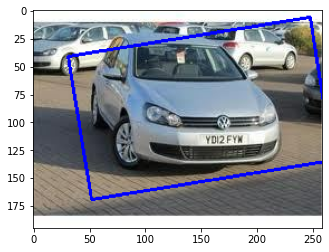

In [96]:
draw_image_with_bbox(item, cam)

## Grad CAM

### Conv5 / Block3

In [97]:
grad_cam = generate_grad_cam(model, 'conv5_block3_out', item)

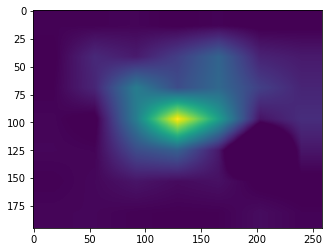

In [98]:
plt.imshow(grad_cam)

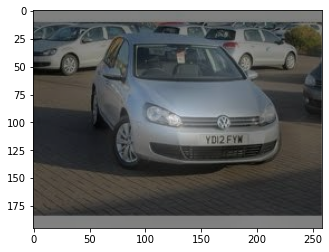

In [99]:
draw_image_with_cam(item, grad_cam)

IoU: 0.6220856999634675


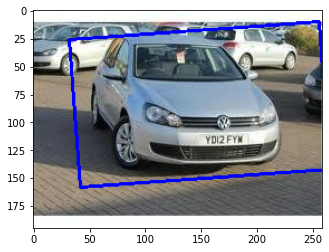

In [100]:
draw_image_with_bbox(item, grad_cam)

### Conv5 / Block2

In [101]:
grad_cam = generate_grad_cam(model, 'conv5_block2_out', item)

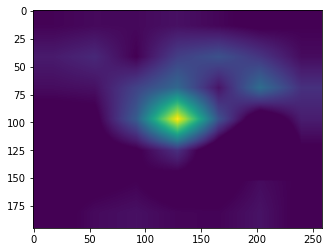

In [102]:
plt.imshow(grad_cam)

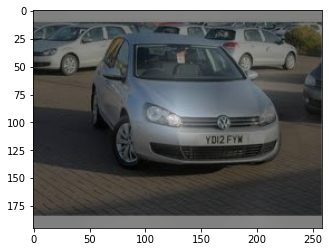

In [103]:
draw_image_with_cam(item, grad_cam)

IoU: 0.5541005625091103


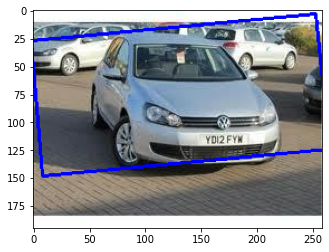

In [104]:
draw_image_with_bbox(item, grad_cam)

### Conv4 / Block3

In [105]:
grad_cam = generate_grad_cam(model, 'conv4_block3_out', item)

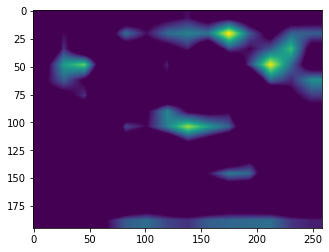

In [106]:
plt.imshow(grad_cam)

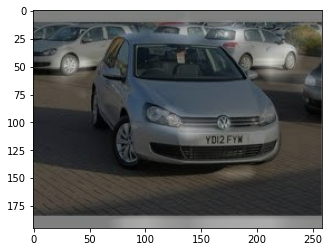

In [107]:
draw_image_with_cam(item, grad_cam)

IoU: 0.0


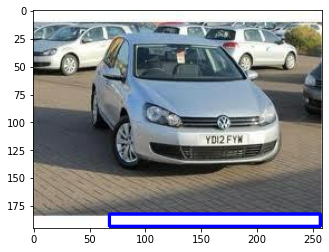

In [108]:
draw_image_with_bbox(item, grad_cam)

### Conv3 / Block3

In [109]:
grad_cam = generate_grad_cam(model, 'conv3_block3_out', item)

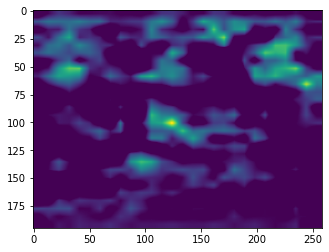

In [110]:
plt.imshow(grad_cam)

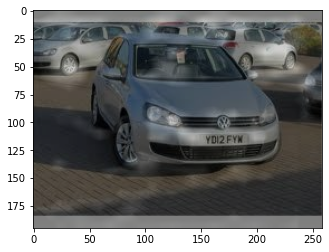

In [111]:
draw_image_with_cam(item, grad_cam)

IoU: 0.0


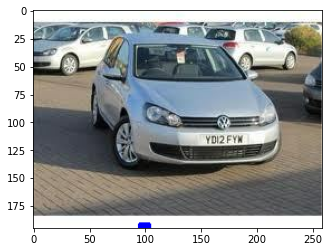

In [112]:
draw_image_with_bbox(item, grad_cam)

# CAM vs Grad CAM

In [113]:
total_iou = 0
grad_total_iou = 0
for i in range(50):
    item = get_single(ds_test)
    image = copy.deepcopy(item['image'])
    
    cam = generate_cam(model, item)
    grad_cam = generate_grad_cam(model, 'conv5_block3_out', item)
    
    rect = get_bbox(cam)
    grad_rect = get_bbox(grad_cam)
    
    pred_bbox = rect_to_minmax(rect, image)
    grad_pred_bbox = rect_to_minmax(grad_rect, image)
    
    iou = get_iou(item['bbox'], pred_bbox)
    grad_iou = get_iou(item['bbox'], grad_pred_bbox)
    
    total_iou += iou
    grad_total_iou += grad_iou

print(f'CAM IoU     : {total_iou/50}')
print(f'Grad CAM IoU: {grad_total_iou/50}')

CAM IoU     : 0.7171610753585074
Grad CAM IoU: 0.5143421818007744


# 결론

Grad CAM의 경우 각 층의 Gradient를 통해 활성화되는 영역을 볼 수 있는 장점이 있지만  
이를 이용해서 object detection을 수행하기에는 정확도가 더 낮았다.   
또, Grad CAM을 이용해서 다양한 층의 활성화 정도를 보는 경우,   
마지막 층을 제외한 다른 층들은 전체 영역을 활성화하기 때문에 object detection과 같은 작업에는 매우 부적합했다.